In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
##go to the code folder where I can import the PDE_models module
%cd 'gdrive/MyDrive/PINN/PINN_program/code/train'

/content/gdrive/MyDrive/PINN/PINN_program/code/train


In [ ]:
##download and install neurodiff
! pip install neurodiffeq

In [4]:
##import our module
from PDE_models import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [5]:
k1 = 2
K2 = np.linspace(1, 2, 8)
A_list = [0.5, -0.5]; b = 0.5; k=16

truth_functions = []; Forcing_functions = []

for k2 in K2:
  for A in A_list:
    truth_functions.append(forcing_decorator_trig(A, k1, k2, b=b))
    Forcing_functions.append(forcing_decorator_trig(-A*np.pi**2*(k1**2 + k2**2), k1, k2, b=0))

#compute the truth solution
truth_solution = [truth_functions[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

In [8]:
##construct a model of 16 heads
k=16
model = Multihead3(k=k, act = nn.functional.silu, bias=True)
model

Multihead3(
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=768, bias=True)
  (final_layers): ModuleList(
    (0-15): 16 x Linear(in_features=256, out_features=1, bias=True)
  )
)

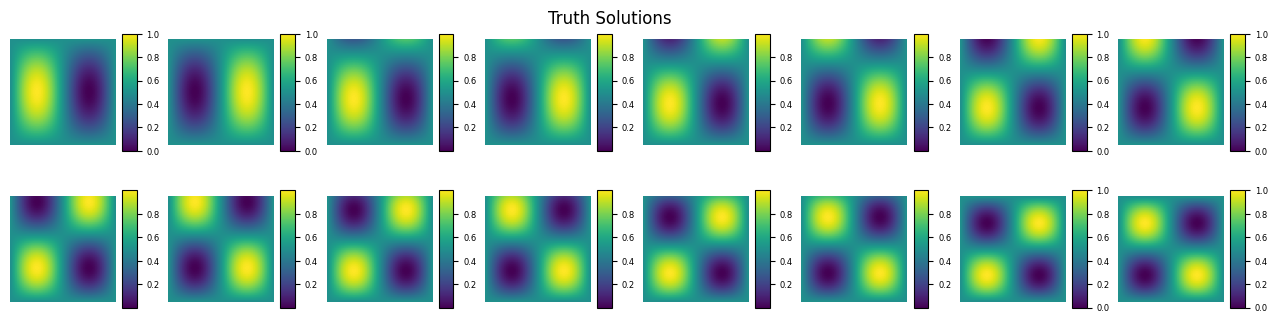

In [6]:
#plot the network solution
plot_solutions16(truth_solution, "Truth Solutions")

In [9]:
##train the network
learning_rate = 1e-3 ##initial learning rate
num_iter= 25000 ##number of iterations
step_size = 100 ##how often the exponential decay is applied
gamma = 0.98 ##exponential decay scale

##define the sampling parameters
interior_grid = (30, 30)
x_boundary_num = 100
t_boundary_num = 100 #on both t boundaries
#define boundary condition
boundary_value = b
##define smapling method
method='equally-spaced-noisy'

##define the weights in each component of the loss
pde_weight = 1; bc_weight = 1; data_weight = 1

##define the optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
##define the exponential learning rate decay scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [10]:
##train the model
loss_trace, pde_trace, bc_trace, data_trace = train(model, optimizer, loss, num_iter, Forcing_functions, truth_functions,
          boundary_value, interior_grid=interior_grid, x_boundary_num=x_boundary_num, t_boundary_num=t_boundary_num,
          every=100, pde_weight=pde_weight, bc_weight=bc_weight, data_weight=data_weight, scheduler=scheduler, method=method)

  0%|          | 0/25000 [00:00<?, ?it/s]

100th Iter: total 1.1901175707067655, pde 1.1215924924846328, bc 0.0463995593737663, data 0.022125518848366513
200th Iter: total 0.14577979827705342, pde 0.12453586965606316, bc 0.015571847494863785, data 0.005672081126126504
300th Iter: total 0.31835935930303655, pde 0.3088063083618344, bc 0.006818046965381287, data 0.002735003975820822
400th Iter: total 0.5392465273218567, pde 0.5345258919982773, bc 0.003494537276782879, data 0.0012260980467966836
500th Iter: total 0.018668466424747544, pde 0.015684035600277566, bc 0.0021795554652847965, data 0.0008048753591851823
600th Iter: total 0.013853119607758169, pde 0.011535870919845486, bc 0.0016663196790160774, data 0.0006509290088966048
700th Iter: total 0.011396302042925922, pde 0.00947112602366959, bc 0.0013445046191979907, data 0.0005806714000583406
800th Iter: total 0.017906196499600496, pde 0.01627794336522732, bc 0.0010820363479155408, data 0.0005462167864576343
900th Iter: total 0.031901384831563455, pde 0.030262950598974454, bc 0.0

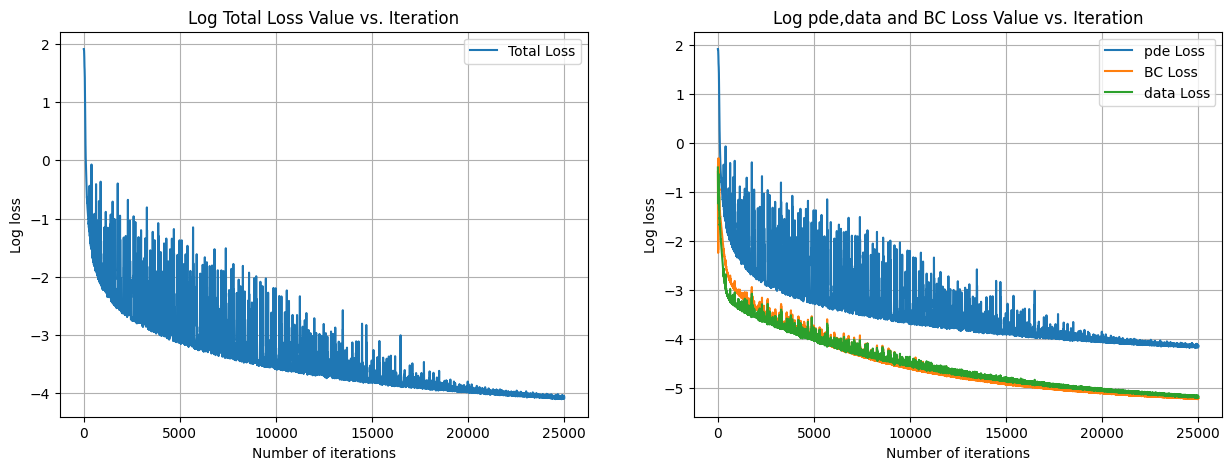

In [11]:
plot_loss(loss_trace, pde_trace, bc_trace, data_trace)

In [12]:
##compute the NN solutions
X_grid = X_grid.to('cuda')
NN_solution, _ = model(X_grid)
NN_solution = NN_solution[:, :, 0].cpu().detach().numpy()
NN_solution = [NN_solution[i, :].reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

In [13]:
##report relative error
r_error = relative_error(NN_solution, truth_solution)
print("Relative Error: {}".format(r_error))

Relative Error: 0.0025645483194126737


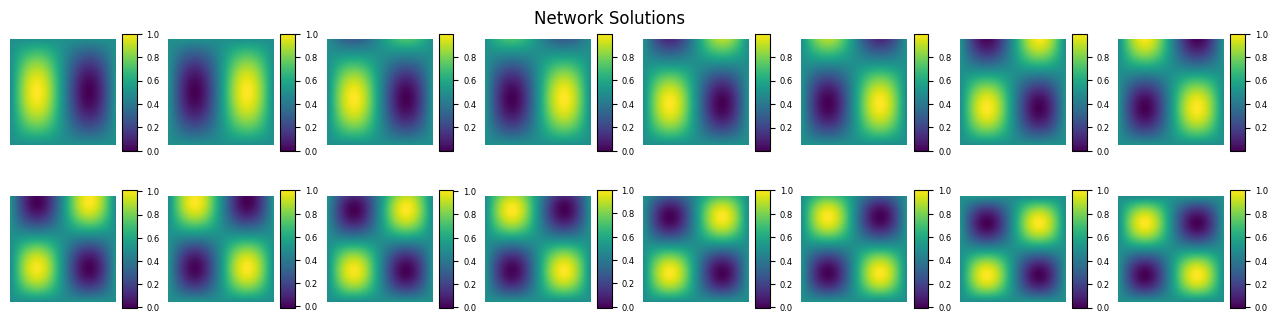

In [14]:
#plot the network solution
plot_solutions16(NN_solution, "Network Solutions")

In [15]:
##log and save the record
log = {
    'model': model,
    'optimizer':optimizer,
    'bias': True,
    'forcing_info': {
        'A': A_list,
        'K1': k1,
        'K2': K2,
        'b': b
    },
    'lr': learning_rate,
    'num_iter': num_iter,
    'step_size': step_size,
    'gamma': gamma,
    'interior_grid': interior_grid,
    'x_boundary_num': x_boundary_num,
    't_boundary_num': t_boundary_num,
    'boundary_value': b,
    'pde_weight': pde_weight,
    'bc_weight': bc_weight,
    'data_weight': data_weight,
    'loss_trace': {
        'total': loss_trace,
        'pde': pde_trace,
        'bc': bc_trace,
        'data': data_trace
    },
    'relative_error': r_error,
    'method': 'equally-spaced-noisy'
}

In [17]:
import pickle
path = 'experiment_log/16head_log_apr3_trig4_1phase.pickle'
file = open(path, 'wb')
pickle.dump(log, file)
file.close()

In [18]:
import pickle
path = 'experiment_log/16head_model_apr3_trig3_1phase.pickle'
file = open(path, 'wb')
pickle.dump(model.cpu(), file)
file.close()